In [63]:
import pandas as pd
import sqlite3
from sqlalchemy import create_engine, text
from sqlalchemy.orm import sessionmaker
from matplotlib import pyplot as plt

In [64]:
# DB connection details
DB_URI = "sqlite:///energy.db"
engine = create_engine(DB_URI, pool_pre_ping=True)

In [65]:
SessionLocal = sessionmaker(
    autocommit=False,
    autoflush=False,
    bind=engine,
)

In [66]:
df = pd.read_csv('energy_dataset.csv')
df["time"] = pd.to_datetime(df["time"])

C:\Users\mahim\AppData\Local\Temp\ipykernel_10656\45565026.py:2: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df["time"] = pd.to_datetime(df["time"])


In [67]:
# Drop columns that are not needed
df.drop(columns='total load forecast', inplace=True)
df.drop(columns='price day ahead', inplace=True)
#convert time column to datatype timestamp
# Convert time value to timestamp
df['time'] = pd.to_datetime(df['time'], utc=True).dt.tz_localize(None)
df.dtypes

time                                           datetime64[ns]
generation biomass                                    float64
generation fossil brown coal/lignite                  float64
generation fossil coal-derived gas                    float64
generation fossil gas                                 float64
generation fossil hard coal                           float64
generation fossil oil                                 float64
generation fossil oil shale                           float64
generation fossil peat                                float64
generation geothermal                                 float64
generation hydro pumped storage aggregated            float64
generation hydro pumped storage consumption           float64
generation hydro run-of-river and poundage            float64
generation hydro water reservoir                      float64
generation marine                                     float64
generation nuclear                                    float64
generati

In [68]:
df.head()

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load actual,price actual
0,2014-12-31 23:00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,73.0,49.0,196.0,0.0,6378.0,17.0,NaN,6436.0,25385.0,65.41
1,2015-01-01 00:00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,71.0,50.0,195.0,0.0,5890.0,16.0,NaN,5856.0,24382.0,64.92
2,2015-01-01 01:00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,73.0,50.0,196.0,0.0,5461.0,8.0,NaN,5454.0,22734.0,64.48
3,2015-01-01 02:00:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,75.0,50.0,191.0,0.0,5238.0,2.0,NaN,5151.0,21286.0,59.32
4,2015-01-01 03:00:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,74.0,42.0,189.0,0.0,4935.0,9.0,NaN,4861.0,20264.0,56.04


In [0]:
# Create table
'''
create_table_query = text(
"""
    CREATE TABLE "power_consumption" (
    "Datetime"	timestamp,
    "Temperature" float,
    "Humidity" float,
    "WindSpeed" float,
    "GeneralDiffuseFlows" float,
    "DiffuseFlows" float,
    "PowerConsumption" float
    );
"""
)
'''

In [72]:
# Create table schema based on DataFrame columns
textstr = "CREATE TABLE IF NOT EXISTS energy_load ("
for column in df.columns:
    # Determine the data type of the column
    data_type = df[column].dtype
    column = column.replace(" ", "_")  # Remove spaces from column names
    column = column.replace("/", "_")  # Remove hyphens from column names
    column = column.replace("(", "")  # Remove opening parentheses from column names
    column = column.replace(")", "")  # Remove closing parentheses from column names
    column = column.replace("%", "Pct")  # Remove percentage sign and replace with "Pct"    
    column = column.replace("-", "_")  # Remove hyphens from column names
    
    # Map Pandas data types to SQLite data types
    if str(data_type) == 'datetime64[ns]':
        sqlite_data_type = 'TIMESTAMP'
    elif str(data_type) == 'object':
        sqlite_data_type = 'TEXT'
    elif str(data_type) == 'float64':
        sqlite_data_type = 'FLOAT'
    else:
        sqlite_data_type = 'TEXT'  # Default to TEXT if data type is not recognized
    
    # Add column and data type to the table schema
    textstr += f"{column} {sqlite_data_type}, "

# Remove trailing comma and space, then close the table schema
textstr = textstr[:-2] + ")"


In [73]:
textstr

'CREATE TABLE IF NOT EXISTS energy_load (time TIMESTAMP, generation_biomass FLOAT, generation_fossil_brown_coal_lignite FLOAT, generation_fossil_coal_derived_gas FLOAT, generation_fossil_gas FLOAT, generation_fossil_hard_coal FLOAT, generation_fossil_oil FLOAT, generation_fossil_oil_shale FLOAT, generation_fossil_peat FLOAT, generation_geothermal FLOAT, generation_hydro_pumped_storage_aggregated FLOAT, generation_hydro_pumped_storage_consumption FLOAT, generation_hydro_run_of_river_and_poundage FLOAT, generation_hydro_water_reservoir FLOAT, generation_marine FLOAT, generation_nuclear FLOAT, generation_other FLOAT, generation_other_renewable FLOAT, generation_solar FLOAT, generation_waste FLOAT, generation_wind_offshore FLOAT, generation_wind_onshore FLOAT, forecast_solar_day_ahead FLOAT, forecast_wind_offshore_eday_ahead FLOAT, forecast_wind_onshore_day_ahead FLOAT, total_load_actual FLOAT, price_actual FLOAT)'

In [74]:
table_schema = text(textstr)
# Create table
with SessionLocal() as session:
    session.execute(table_schema)

In [75]:
# Insert data into table
with SessionLocal() as session:
    df.to_sql("energy_load", con=session.get_bind(), if_exists="append", index=False)
    session.commit()

In [76]:

# Now we have already filled the table, we can query it
with SessionLocal() as session:
    query = text(
        """
        SELECT *
        FROM energy_load
        """
    )
    data = session.execute(query)


In [77]:
    df = pd.DataFrame(data)
    print(df.head())

                         time  generation biomass  \
0  2014-12-31 23:00:00.000000               447.0   
1  2015-01-01 00:00:00.000000               449.0   
2  2015-01-01 01:00:00.000000               448.0   
3  2015-01-01 02:00:00.000000               438.0   
4  2015-01-01 03:00:00.000000               428.0   

   generation fossil brown coal/lignite  generation fossil coal-derived gas  \
0                                 329.0                                 0.0   
1                                 328.0                                 0.0   
2                                 323.0                                 0.0   
3                                 254.0                                 0.0   
4                                 187.0                                 0.0   

   generation fossil gas  generation fossil hard coal  generation fossil oil  \
0                 4844.0                       4821.0                  162.0   
1                 5196.0                      

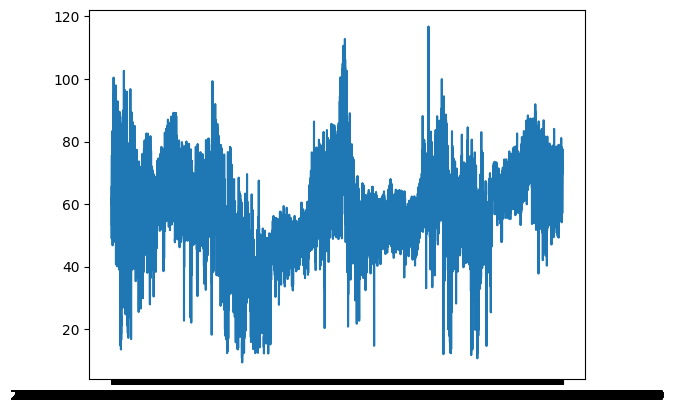

In [81]:
# Now we can plot the data using dataframe df
plt.plot(df["time"], df["price actual"])
plt.show()
